In [1]:
%load_ext autoreload
%autoreload 2
import scipy
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import keras

import time

2024-08-23 12:32:07.067848: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-23 12:32:08.147754: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-23 12:32:08.147819: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-23 12:32:08.323680: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-23 12:32:08.717141: I tensorflow/core/platform/cpu_feature_guar

## Observations
At each timestep $t$, we observe $S=1$ artificial locations. The observed value $y_{s,t}$ is realization of random variable $Y_s$, which is normally distributed with unit variance and a location-specific mean: $Y_{s,t} \sim \mathcal{N}(\mu_s, 1)$. The mean is $\mu = [10]$.

In [2]:
S=1
scale = 1
means = [10]
# simulate data for each location
data_distributions = [scipy.stats.norm(loc=mean, scale=scale) for mean in means]

In total, we observe $T=1000$ examples. We frame this as a machine learning problem and our goal is to train a model to accurately predict $y$.

In [3]:
T=1000
# create random state for sampling
seed=360
rng = np.random.RandomState(seed)
y_TS = np.array([dist.rvs(size=T, random_state=rng) for dist in data_distributions]).T
assert(y_TS.shape == (T, S))

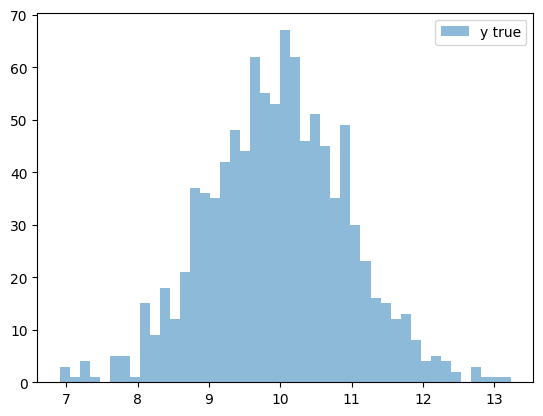

In [4]:
plt.hist(tf.reshape(y_TS, [-1]).numpy(),alpha=0.5, bins=45, label='y true')
plt.legend()

## Model
We will model this with the true model: predictions $\hat{y}_{s,t}$ will come from S, location-specific normal distributions, where the mean is determined by a function $f_{\phi_s}(x)$ with location-specific parameters $\phi_s$, and the variance is fixed to the true value of 1.

$$p(\hat{y}_{s,t}) = \mathcal{N}(\hat{y}_{s,t}| \phi_s, 1)$$
All locations are independent:
$$p(\hat{y}_{t}) = \prod_{s=1}^S \mathcal{N}(\hat{y}_{s,t}| \phi_s, 1)$$


Our model can trivially recover the true data generating process by setting the parameter to the true mean $\phi_s = \mu_s$

## Objective
We will use our model's predictions $\hat{y}$ in order to choose some action $\theta$, which can be calculated by a deterministic but not necessarily differentiable function $a$ of $\hat{y}$:
$$\theta_t = a(\hat{y}_t)$$

Given a decision $\theta$, we can calculate a loss between our action and the observed outcome $\mathcal{L}(\theta_t, y_t)$. Our goal is to calculate gradients of that loss with respect to our model parameters. We can use the chain rule to decompose the gradient into two parts:
$$ \nabla_\phi \mathcal{L}(\theta_t, y_t) = \nabla_\phi \theta \nabla_\theta  \mathcal{L}(\theta_t, y_t)$$

When $\theta$ is non-differentiable, we can obtain gradients using the score-function trick, where we can approximate the gradient using $M$ samples from our probabilistic model $p$
$$\nabla_\phi \theta = \frac{1}{M} \sum_{m=1}^M \nabla_\phi \log p(y^m) a(y^m)$$

Our loss is mean-squared error and easy to differentiate: 
$$\mathcal{L} (\theta_t, y_t) = \frac{1}{S}\sum_{s=1}^S(y_t-\theta_t)^2$$

## Implementing the model

In [5]:
inputs = keras.Input(shape=0)
linear_layer = keras.layers.Dense(S, activation = None)
distribution_layer = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc=t, scale=1))

In [6]:
predicted_means = linear_layer(inputs)
distributions = distribution_layer(predicted_means)
model = keras.Model(inputs=inputs, outputs=distributions)

In [7]:
x_TF = np.zeros(shape=(1000,0))
model_distributions = model(x_TF)
print(f'Model parameter shapes: {[w.shape for w in model.get_weights()]}')

Model parameter shapes: [(0, 1), (1,)]


### Set weights to true values
Just set the bias to the true mean

In [8]:
biases = model.trainable_variables[1]
biases.assign(means)

print(f'Biases {model.get_weights()[1]}')

Biases [10.]


In [9]:
M=500
model_distributions = model(x_TF)
sample_y_MTS = model_distributions.sample(M)
assert(sample_y_MTS.shape == (M, T, S))

sample_log_probs_MTS = model_distributions.log_prob(sample_y_MTS)
sample_actions_MTS = tf.identity(sample_y_MTS)
expected_actions_TS = tf.reduce_mean(sample_actions_MTS, axis=0)
loss_T = keras.losses.mean_squared_error(y_TS, expected_actions_TS)
loss = tf.reduce_mean(loss_T)

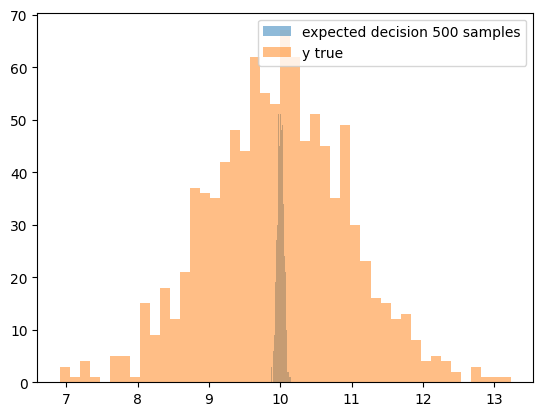

In [10]:
plt.hist(tf.reshape(expected_actions_TS, [-1]).numpy(),alpha=0.5, bins=45, label=f'expected decision {M} samples')
plt.hist(tf.reshape(y_TS, [-1]).numpy(),alpha=0.5, bins=45, label='y true')
plt.legend()

### Differentiate the score function trick
We'll take $M=5$ samples, and use the identity function as our action $a(y)=y$
$$ \nabla_\phi \mathcal{L}(\theta_t, y_t) = \nabla_\phi \theta \nabla_\theta  \mathcal{L}(\theta_t, y_t)$$

When $\theta$ is non-differentiable, we can obtain gradients using the score-function trick, where we can approximate the gradient using $M$ samples from our probabilistic model $p$
$$\nabla_\phi \theta = \frac{1}{M} \sum_{m=1}^M \nabla_\phi \log p(y^m) a(y)$$

Our loss is mean-squared error and easy to differentiate: 
$$\mathcal{L} (\theta_t, y_t) = \frac{1}{S}\sum_{s=1}^S(y_t-\theta_t)^2$$

$$\nabla_\phi \log p(y^m) = \nabla_\phi \left( -\log (\sigma) - \frac{1}{2}\log (2\pi) - \frac{1}{2}(\frac{y^m-\phi_\mu}{\sigma})^2 \right)$$

$$ \nabla_\phi \log p(y^m) = \frac{y^m-\phi_\mu}{\sigma^2} = y^m -\phi_\mu$$

$$\nabla_\phi \theta = \frac{1}{M} \sum_{m=1}^M (y^m - \phi_\mu) a(y)$$

 $$\nabla_\theta  \mathcal{L}(\theta_t, y_t) =  \nabla_\theta   \frac{1}{S}\sum_{s=1}^S(y_t-\theta_t)^2$$

$$ = \frac{1}{S}\sum_{s=1}^S-2(y_t-\theta_t)$$

In [11]:
M=3
model_distributions = model(x_TF)
sample_y_MTS = model_distributions.sample(M)
grad_theta_wrt_phi_TS = tf.reduce_mean((sample_y_MTS - model.trainable_variables[1])*sample_y_MTS, axis=0)

sample_actions_MTS = tf.identity(sample_y_MTS)
expected_actions_TS = tf.reduce_mean(sample_actions_MTS, axis=0)
loss_T = keras.losses.mean_squared_error(y_TS, expected_actions_TS)
loss = tf.reduce_mean(loss_T)
grad_L_wrt_theta_TS = -2.0*(y_TS-expected_actions_TS)

analytical_gradient_TS = grad_theta_wrt_phi_TS*grad_L_wrt_theta_TS

In [17]:
M=2

analytical_grads, autodiff_grads, losses, param_vals,big_analytical, big_sample, big_grad_theta, big_grad_L = [], [], [], [], [], [], [], []


for param_value in np.linspace(5, 15, 21, dtype=np.float32):
    print(param_value)
    mean_param = [param_value]
    variable = model.trainable_variables[1]
    variable.assign(mean_param)

    start = time.time()

    for trial in range(100):
        with tf.GradientTape() as master_tape:
            model_distributions = model(x_TF)
            sample_y_MTS = model_distributions.sample(M)
            stopped_samples_MTS = tf.stop_gradient(sample_y_MTS)
            sample_log_probs_MTS = model_distributions.log_prob(stopped_samples_MTS)
            grad_theta_wrt_phi_MTS = (sample_y_MTS - model.trainable_variables[1])*sample_y_MTS
            grad_theta_wrt_phi_TS = tf.reduce_mean(grad_theta_wrt_phi_MTS, axis=0)

            sample_actions_MTS = tf.identity(sample_y_MTS)
            expected_actions_TS = tf.reduce_mean(sample_actions_MTS, axis=0)
            loss_T = keras.losses.mean_squared_error(y_TS, expected_actions_TS)
            loss = tf.reduce_mean(loss_T)
            grad_L_wrt_theta_TS = -2.0/S*(y_TS-expected_actions_TS)

        analytical_gradient_MTS = grad_theta_wrt_phi_MTS*tf.expand_dims(grad_L_wrt_theta_TS,axis=0)
        analytical_gradient_TS = grad_theta_wrt_phi_TS*grad_L_wrt_theta_TS
        master_gradient = master_tape.gradient(loss_T, model.trainable_weights)
        autodiff_grads.append(master_gradient[1][0])
        losses.append(loss)
        analytical_grads.append(tf.reduce_mean(analytical_gradient_TS, axis=0)[0])
        big_analytical.append(analytical_gradient_MTS)
        big_sample.append(sample_y_MTS)
        big_grad_theta.append(grad_theta_wrt_phi_MTS)
        big_grad_L.append(grad_L_wrt_theta_TS)
        param_vals.append(param_value)
    end = time.time()
    elapsed = end - start
    print(f'Elapsed time {elapsed}')

5.0
Elapsed time 0.9904525279998779
5.5
Elapsed time 0.9966263771057129
6.0
Elapsed time 1.0462169647216797
6.5
Elapsed time 0.9944169521331787
7.0
Elapsed time 1.003328561782837
7.5
Elapsed time 1.020573377609253
8.0
Elapsed time 0.9880342483520508
8.5
Elapsed time 1.0469276905059814
9.0
Elapsed time 0.9815807342529297
9.5
Elapsed time 0.9819033145904541
10.0
Elapsed time 1.0449340343475342
10.5
Elapsed time 0.9852910041809082
11.0
Elapsed time 1.0575766563415527
11.5
Elapsed time 0.9810001850128174
12.0
Elapsed time 0.9815948009490967
12.5
Elapsed time 1.0545272827148438
13.0
Elapsed time 1.023348093032837
13.5
Elapsed time 1.0518264770507812
14.0
Elapsed time 0.9839260578155518
14.5
Elapsed time 0.9809021949768066
15.0
Elapsed time 1.043529748916626


In [13]:

M=1000

analytical_grads1k, autodiff_grads1k, losses1k, param_vals1k, big_analytical1k, big_sample1k, big_grad_theta1k, big_grad_L1k = [], [], [], [], [], [], [], []


for param_value in np.linspace(5, 15, 21, dtype=np.float32):
    print(param_value)
    mean_param = [param_value]
    variable = model.trainable_variables[1]
    variable.assign(mean_param)

    start = time.time()

    for trial in range(100):
        with tf.GradientTape() as master_tape:
            model_distributions = model(x_TF)
            sample_y_MTS = model_distributions.sample(M)
            sample_y_MTS = sample_y_MTS[:2,:,:]
            stopped_samples_MTS = tf.stop_gradient(sample_y_MTS)
            sample_log_probs_MTS = model_distributions.log_prob(stopped_samples_MTS)
            grad_theta_wrt_phi_MTS = (sample_y_MTS - model.trainable_variables[1])*sample_y_MTS
            grad_theta_wrt_phi_TS = tf.reduce_mean(grad_theta_wrt_phi_MTS, axis=0)

            sample_actions_MTS = tf.identity(sample_y_MTS)
            expected_actions_TS = tf.reduce_mean(sample_actions_MTS, axis=0)
            loss_T = keras.losses.mean_squared_error(y_TS, expected_actions_TS)
            loss = tf.reduce_mean(loss_T)
            grad_L_wrt_theta_TS = -2.0/S*(y_TS-expected_actions_TS)

        analytical_gradient_MTS = grad_theta_wrt_phi_MTS*tf.expand_dims(grad_L_wrt_theta_TS,axis=0)
        analytical_gradient_TS = grad_theta_wrt_phi_TS*grad_L_wrt_theta_TS
        master_gradient = master_tape.gradient(loss_T, model.trainable_weights)
        autodiff_grads1k.append(master_gradient[1][0])
        losses1k.append(loss)
        analytical_grads1k.append(tf.reduce_mean(analytical_gradient_TS, axis=0)[0])
        big_analytical1k.append(analytical_gradient_MTS)
        big_sample1k.append(sample_y_MTS)
        big_grad_theta1k.append(grad_theta_wrt_phi_MTS)
        big_grad_L1k.append(grad_L_wrt_theta_TS)
        param_vals1k.append(param_value)
    end = time.time()
    elapsed = end - start
    print(f'Elapsed time {elapsed}')

5.0
Elapsed time 2.754251003265381
5.5
Elapsed time 2.8061342239379883
6.0
Elapsed time 2.7656116485595703
6.5
Elapsed time 2.655526638031006
7.0
Elapsed time 2.7829625606536865
7.5
Elapsed time 2.6928539276123047
8.0
Elapsed time 2.7095727920532227
8.5
Elapsed time 2.7565133571624756
9.0
Elapsed time 2.6590819358825684
9.5
Elapsed time 2.75555419921875
10.0
Elapsed time 2.704904317855835
10.5
Elapsed time 2.6817545890808105
11.0
Elapsed time 2.765117645263672
11.5
Elapsed time 2.6305992603302
12.0
Elapsed time 3.014390707015991
12.5
Elapsed time 2.8692257404327393
13.0
Elapsed time 2.6423683166503906
13.5
Elapsed time 2.747086763381958
14.0
Elapsed time 2.634608745574951
14.5
Elapsed time 2.900280714035034
15.0
Elapsed time 2.9431681632995605


In [13]:
def plot_big_results(analytical_grads_MTS, autodiff_grads, losses, param_vals, T,M, num_rows=2, title=None, limit_y=True):
    analytical_grads = [tf.reduce_mean(tf.reduce_mean(grad_MTS[:num_rows,:,:], axis=0), axis=0) [0] for grad_MTS in analytical_grads_MTS]

    # plot with 2 different scales, 1 y axis for each graph:
    fig, ax1 = plt.subplots()

    # Plot the first line on ax1
    ax1.set_xlabel('3rd cluster mean')
    #ax1.set_ylabel('loss')
    ax1.plot(param_vals, losses, label='loss')
    
    ax1.tick_params(axis='y')
    if limit_y:
        ax1.set_ylim([-10, 10])
    plt.legend()
    # Create ax2, which shares the same x-axis as ax1
    ax2 = ax1#.twinx()
    #ax2.set_ylabel('gradient')
    # divide by 1000 because autodiff is summing over samples
    ax2.plot(param_vals, [mag/T for mag in autodiff_grads], 'g-', label='autodiff gradient')
    ax2.plot(param_vals, analytical_grads,'k*',label='score func gradient', )
    ax2.tick_params(axis='y')
    #ax2.set_ylim([-10,10])

    #ax2.set_ylim([-1000, 1000])
    #plot vertical line at x=25
    plt.axvline(x=10, color='r', linestyle='--', label='true mean')
    plt.axhline(y=0, color='r', linestyle=':', label='0 gradient')
    fig.tight_layout()
    plt.legend()

    if title is None:
        title = f'Loss and gradients score_func samples M={M}, first {num_rows} taken'

    plt.title(title)
    plt.show()


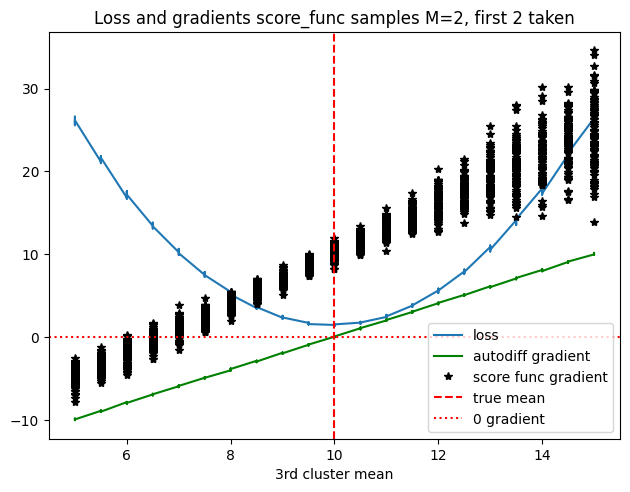

NameError: name 'big_analytical1k' is not defined

In [18]:
plot_big_results(big_analytical, autodiff_grads, losses, param_vals, T, M=2, limit_y=False)
plot_big_results(big_analytical1k, autodiff_grads1k, losses1k, param_vals1k, T, M=1000, num_rows=2, limit_y=False)